<a href="https://colab.research.google.com/github/jdcneto/Fundamentals-of-Computer-Vision/blob/main/Trans_Pontuais_e_Suaviza%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformações Pontuais e Filtros de suavização

### Definindo as funções de correlação e convolução

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from ipywidgets import interact, IntSlider,FloatSlider
import scipy
import os
%matplotlib inline

### Fazendo download das imagens necessárias:

In [2]:
import urllib.request
try:
  urllib.request.urlretrieve("https://github.com/jdcneto/Fundamentals-of-Computer-Vision/raw/main/dados/cameraman.tiff", "cameraman.tiff")
except:
    print('Error')
try:
  urllib.request.urlretrieve("https://github.com/jdcneto/Fundamentals-of-Computer-Vision/raw/main/dados/city_dark.tiff", "city_dark.tiff")
except:
    print('Error')    
try:
  urllib.request.urlretrieve("https://github.com/jdcneto/Fundamentals-of-Computer-Vision/raw/main/dados/pacman.tiff", "pacman.tiff")
except:
    print('Error') 
try:
  urllib.request.urlretrieve("https://github.com/jdcneto/Fundamentals-of-Computer-Vision/raw/main/dados/aerial.tif", "aerial.tif")
except:
    print('Error')       

Definindo as funções de correlação e convolução:

In [3]:
def correlation(img, w):
    '''Calcula a correlação cruzada entre a imagem img e o filtro w.
    
       Parâmetros
       ----------
       img : numpy array.
           Imagem a ser filtrada.
       w : numpy array.
           Filtro a ser utilizada na correlação cruzada.
       
       Return
       -------
       img_filtered : numpy array, mesmo tamanho que img
           Imagem filtrada
    '''

    numRows, numCols = img.shape
    fNumRows, fNumCols = w.shape   # fNumRows=a+1 e fNumCols=b+1 (a e b da fórmula acima)

    halfRSize = fNumRows//2        # O operador // retorna a parte inteira da divisão
    halfCSize = fNumCols//2

    imgPadded = np.zeros((numRows+fNumRows-1, numCols+fNumCols-1), dtype=img.dtype)
    for row in range(numRows):
        for col in range(numCols):   
            imgPadded[row+halfRSize, col+halfCSize] = img[row, col]
    # A estrutura for aninhada acima pode ser substituída por
    #imgPadded = np.pad(img, ((halfRSize,halfRSize),(halfCSize,halfCSize)), mode='constant')
    
    img_filtered = np.zeros((numRows, numCols))
    for row in range(numRows):
        for col in range(numCols):
            sum_region = 0
            for s in range(fNumRows):
                for t in range(fNumCols):
                    # O índice do array na soma abaixo é diferente do utilizado na fórmula da 
                    # correlação porque estamos utilizando a imagem preenchida com zeros. O 
                    # pixel (0,0)  na imagem preenchida corresponde ao pixel (x+s-a/2, y+t-b/2) 
                    # da imagem original
                    sum_region += w[s, t]*imgPadded[row+s, col+t]
            img_filtered[row, col] = sum_region

            # O loop aninhado acima pode ser substituído por
            # patch = imgPadded[row:row+fNumRows, col:col+fNumCols]
            # img_filtered[row, col] = np.sum(w*patch)
            
    return img_filtered

def convolution(img, w):
    '''Calcula a convolução entre a imagem img e o filtro w.
    
       Parâmetros
       ----------
       img : numpy array.
           Imagem a ser filtrada.
       w : numpy array.
           Filtro a ser utilizada na correlação cruzada.
       
       Return
       -------
       img_filtered : numpy array, mesmo tamanho que img
           Imagem filtrada
    '''
    # Inverte o filtro
    w_inv = w[::-1, ::-1]

    img_filtered = correlation(img, w_inv)

    return img_filtered

Um pequeno teste:

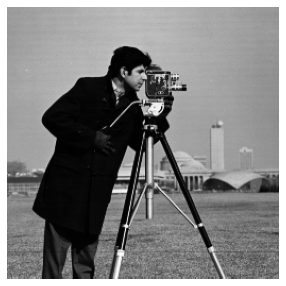

In [4]:
img = cv2.imread('cameraman.tiff', 0)
plt.figure(figsize=[5,5])
plt.imshow(img, 'gray')
plt.axis('off');

# Transformações Pontuais


A formula geral da transformação logarítmica ($log$) é dada por:

$$g(x,y) = c \cdot log(f(x,y) + 1),$$

onde $c$ é uma constante. A figura 1 ilustra essa transformação, bem como algumas outras transformações úteis.

<center><img src="https://github.com/jdcneto/Fundamentals-of-Computer-Vision/blob/main/dados/log.png?raw=true" width="353" height="320"></center>

<center><caption><b>Figura 1:</b> Exemplos de transformações ponto a ponto.</b></caption></center>
<caption><center> Referência: Gonzalez and Woods, Digital Image Processing 3rd.</center></caption>

A equação da transformação *gamma* é dada por:

$$g(x,y) = c \cdot f(x,y)^\gamma$$

onde $g(x,y)$ é a imagem de entrada, $f(x,y)$ a imagem de entrada, C e $\gamma$ hiperparâmetros. Como no caso da transformação logarítmica, curvas de transformação de potência com valores de $\gamma$ menores que 1 mapeiam uma faixa estreita de valores escuros de entradas em uma faixa mais ampla de valores de saída, com o oposto se aplicando a valores mais altos de níveis de entrada. Os formatos das curvas com diferentes valores de *gamma* é mostrado na figura 2. Usa-se esse tipo de transformação onde se exige uma maior fidelidade na exibição da imagem e para realce de contraste.

<center><img src="https://github.com/jdcneto/Fundamentals-of-Computer-Vision/blob/main/dados/gamma.png?raw=true" width="365" height="330"></center>

<center><caption><b>Figura 2:</b> Curvas com diferentes valores de $\gamma$.</b></caption></center>
<caption><center>Referência: Gonzalez and Woods, Digital Image Processing 3rd.</center></caption>

Exemplos:

Extraindo o negativo de uma imagem:

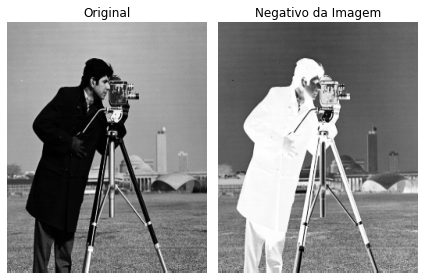

In [5]:
# Negativo, utilizando o numpy
img_neg = 255 - img


plt.subplot(1,2,1)
plt.imshow(img, 'gray', aspect="auto")
plt.title('Original'); plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_neg, 'gray', aspect="auto")
plt.title('Negativo da Imagem'); plt.axis('off')
plt.tight_layout()

Transformação Logarítmica

In [6]:
# Transformação logarítmica
def log_map(img):
    num_linhas, num_cols = img.shape
    img_log = np.zeros((num_linhas, num_cols), dtype=np.float)
    for row in range(num_linhas):
        for col in range(num_cols):
            img_log[row, col] = np.log(1+img[row, col])
            
    return img_log

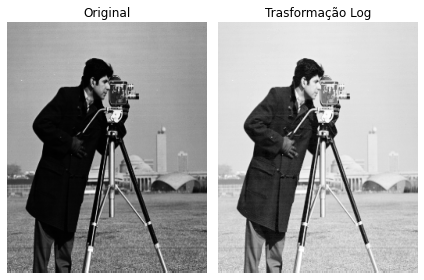

In [7]:
# Simulando uma situação na qual o logaritmo seria util
img_sim = img.astype(float)
img_sim_log = log_map(img_sim)

plt.subplot(1,2,1)
plt.imshow(img_sim, 'gray', aspect="auto")
plt.title('Original'); plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_sim_log, 'gray', aspect="auto")
plt.title('Trasformação Log'); plt.axis('off')
plt.tight_layout()

Transformação gamma

In [8]:
# exemplo de correção gamma com C = 1 e gamma = [0-5]
# Espalhamento de contraste
image = cv2.imread('aerial.tif', 0)
@interact(gamma = FloatSlider(min = 0, max = 5, step = 0.2, value = 0.0))
def _(gamma):
    plt.figure(figsize=[5,5])
    img2 = (image**gamma)
    plt.imshow(img2, 'gray')
    plt.axis('off')

interactive(children=(FloatSlider(value=0.0, description='gamma', max=5.0, step=0.2), Output()), _dom_classes=…

## Equalização de histograma

Seja $n_k$ o número de pixels na imagem possuindo o $k$-ésimo nível de intensidade (por exemplo, o primeiro nível com valor 0, o segundo com valor 1, e assim por diante), a transformação de equalização de histograma é dada por

\begin{equation}
s_k = T(k) = \frac{L-1}{MN}\sum_{j=0}^{k}n_j
\end{equation}
onde $s_k$ é o $k$-ésimo nível de intensidade após a transformação, $L$ o número de níveis de intensidade na imagem e $N$ e $M$ o número de linhas e colunas da imagem.

Exemplo de utilização da equalização de histograma:

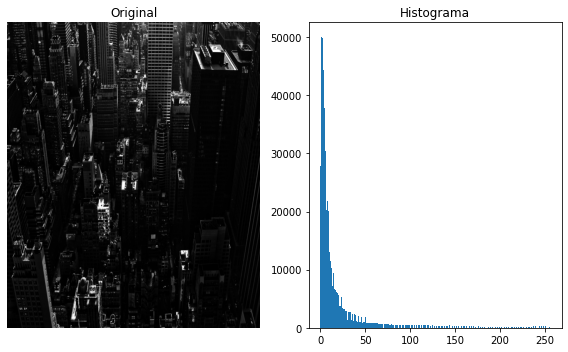

In [9]:
city_img = cv2.imread('city_dark.tiff', 0)
plt.figure(figsize=[8,5])

plt.subplot(1,2,1)
plt.imshow(city_img, 'gray', aspect = 'auto')
plt.title('Original'); plt.axis('off')

plt.subplot(1,2,2)
plt.hist(city_img.ravel(), 256, [0, 256])
plt.title('Histograma');
plt.tight_layout()


Equalizando a imagem:

In [10]:
eq_img = cv2.equalizeHist(city_img)

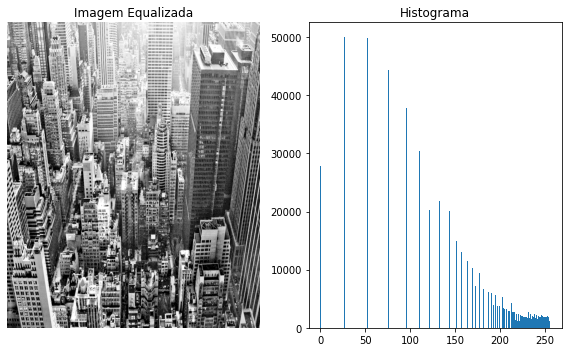

In [11]:
plt.figure(figsize=[8,5])

plt.subplot(1,2,1)
plt.imshow(eq_img, 'gray', aspect = 'auto')
plt.title('Imagem Equalizada'); plt.axis('off')

plt.subplot(1,2,2)
plt.hist(eq_img.ravel(), 256, [0, 256])
plt.title('Histograma');
plt.tight_layout()

# Filtro de média simples

O filtro média atua substituiindo o valor do pixel central de uma janela pela média aritmética dos valores dos pixels  contidos nela. Por ser um passa-baixas, quanto maior for a janela, mais borrada a imagem resultante (blurring).

Exemplo de Aplicação:

In [12]:
# Cria filtro de média simples com tamanho S
S = 5
w = np.full([S,S], 1./S**2)
print(w)

[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]


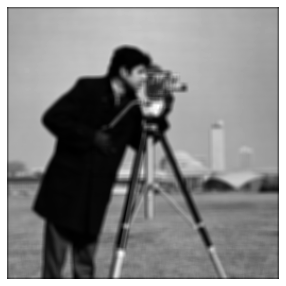

In [13]:
img_smoothed = convolution(img, w)
plt.figure(figsize=[5,5])
plt.imshow(img_smoothed, cmap = 'gray')
plt.axis('off');

# Filtro de suavização gaussiana

Lembrando que a função gaussiana é definida pela equação
\begin{equation}
y(x) = \frac{1}{\sigma\sqrt{2\pi}}exp\left({-\frac{(x-\mu)^2}{2\sigma^2}}\right)
\end{equation}
onde $\mu$ é o ponto central da função. Consideraremos que $\mu=0$

## 1. Visualização da função gaussiana

In [14]:
@interact(sigma = IntSlider(min = 0, max = 10, step = 1, value=1))
def _(sigma):
    x = np.linspace(-5*sigma, 5*sigma, 1000)
    y = np.exp(-x**2/(2*sigma**2))
    y = y/(sigma*np.sqrt(2*np.pi))
    plt.ylim([0,.4]), plt.xlim([-15,15])
    plt.plot(x, y);

interactive(children=(IntSlider(value=1, description='sigma', max=10), Output()), _dom_classes=('widget-intera…

## 2. Filtro gaussiano em uma dimensão

In [15]:
def gaussian_filter_1d(filter_size):
    sigma = filter_size/6.
    x = np.linspace(-3*sigma, 3*sigma, filter_size)
    y = np.exp(-x**2/(2*sigma**2))
    
    # Filtros de suavização precisam ter soma igual a 1
    y = y/np.sum(y)

    return y

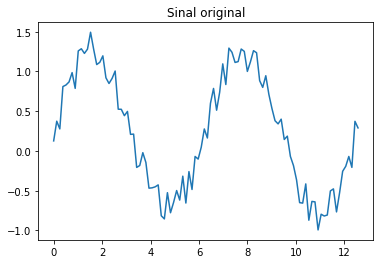

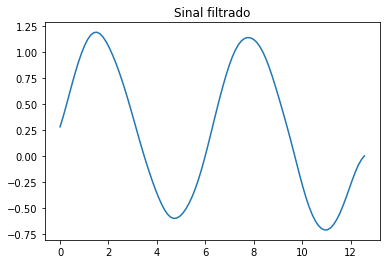

In [16]:
# Filtragem de uma função seno ruidosa
# Cria função seno com um 'pouco' de ruído
x = np.linspace(0, 4*np.pi, 100)
corrupted_sin = np.sin(x) + .5*np.random.rand(len(x))
plt.plot(x, corrupted_sin)
plt.title('Sinal original')

# Filtra sinal
S = 21
w = gaussian_filter_1d(S).reshape(1, S)
corrupted_sin = corrupted_sin.reshape(1, len(corrupted_sin))
filtered_signal = convolution(corrupted_sin, w)
plt.figure()
plt.plot(x, filtered_signal[0])
plt.title('Sinal filtrado');

## 3. Filtro gaussiano bidimensional

Função gaussiana em duas dimensões:

\begin{equation}
z(x) = \frac{1}{2\pi\sigma^2}exp\left({-\frac{(x-\mu_x)^2 + (y-\mu_y)^2}{2\sigma^2}}\right)
\end{equation}
onde $\mu_x$ e $\mu_y$ indicam o ponto central da função em $x$ e $y$. Consideraremos que o centro da função é a origem ($\mu_x=0$ e $\mu_y=0$).
<br>
O filtro gaussiano é um filtro linear do tipo passa-baixas. Este apresenta bons resultados no tratamento de imagens com ruído gaussiano. 

In [17]:
def gaussian_filter_2d(filter_size):
    sigma = filter_size/6.
    x_vals = np.linspace(-3*sigma, 3*sigma, filter_size)
    y_vals = x_vals.copy()
    z = np.zeros((filter_size, filter_size))
    for row in range(filter_size):
        x = x_vals[row]
        for col in range(filter_size):
            y = y_vals[col]
            z[row, col] = np.exp(-(x**2+y**2)/(2*sigma**2))
    z = z/np.sum(z)

    return z

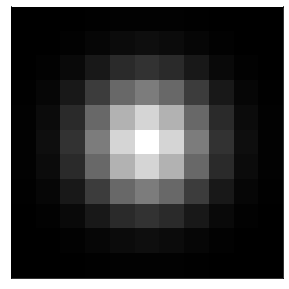

In [18]:
kernel = gaussian_filter_2d(11)
plt.figure(figsize=[5,5])
plt.imshow(kernel, 'gray')
plt.xticks([]), plt.yticks([]);

Exemplo com o OpenCV

In [19]:
# Colocando ruído aditivo
H, W = img.shape[0], img.shape[1]
img_noised = 50*np.random.rand(H, W) + img

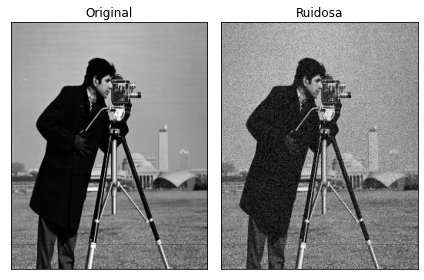

In [20]:
# Visualização
plt.subplot(1,2,1)
plt.imshow(img, 'gray', aspect="auto")
plt.title('Original')
plt.xticks([]), plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(img_noised, 'gray', aspect="auto")
plt.title('Ruidosa')
plt.xticks([]), plt.yticks([])
plt.tight_layout();

In [21]:
# Aplicação filtro gaussiano nxn
tam = 5
gauss_filtered = cv2.GaussianBlur(img_noised, (tam,tam), 0)

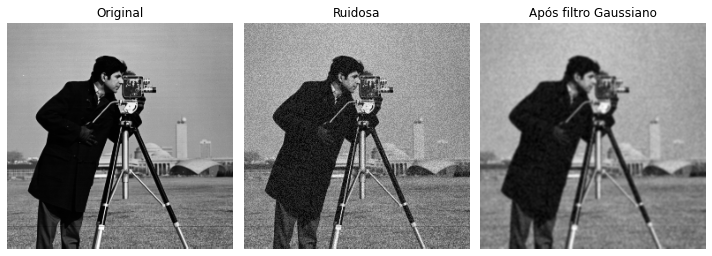

In [22]:
# Visualizando resultado final
plt.figure(figsize=[10,10])
plt.subplot(1,3, 1); plt.imshow(img, 'gray')
plt.title('Original'); plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(img_noised, 'gray')
plt.title('Ruidosa'); plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(gauss_filtered, 'gray')
plt.title('Após filtro Gaussiano'); plt.axis('off')
plt.tight_layout();

# Filtro da Mediana

Uma transformação bastante usada para suavizar ruído do tipo impulsivo em sinais e imagens digitais.
 
Consiste em substituir a intensidade de cada pixel pela mediana das intensidades na vizinhança do pixel. Para uma vizinhança de n$\times$n pixels, sendo n ímpar, a mediana das intensidades ordenadas encontra-se na posição $\dfrac{(n^2 + 1)}{2}$.
O filtro da mediana é adequado para reduzir o efeito de ruído impulsivo do tipo sal-e-pimenta, já que os níveis de cinza dos pixels que diferem significativamente de seus vizinhos (valores altos ou baixos), em uma dada vizinhança, serão descartados pelo filtro. Além disso, não introduz valores em escala de cinza diferentes daqueles contidos na imagem original e, por afetar menos as bordas, pode ser aplicado iterativamente.

Contras: Custo computacional elevado devido ao processo de ordenação característico do cálculo da mediana.


Exemplo de Aplicação de Filtro de Mediana

In [23]:
# Adiciona ruído do tipo salt and pepper
def add_noise(image, n_pixels):
    img = np.copy(image)
    row , col = img.shape
      
    #sal
    number_of_pixels = n_pixels
    for i in range(number_of_pixels):
        y_coord=random.randint(0, row - 1)
        x_coord=random.randint(0, col - 1)
          
        img[y_coord][x_coord] = 255
          
    #pimenta
    number_of_pixels = n_pixels
    for i in range(number_of_pixels):
        y_coord=random.randint(0, row - 1)
        x_coord=random.randint(0, col - 1)

        img[y_coord][x_coord] = 0
          
    return img

noisy_image = add_noise(img, 1000)

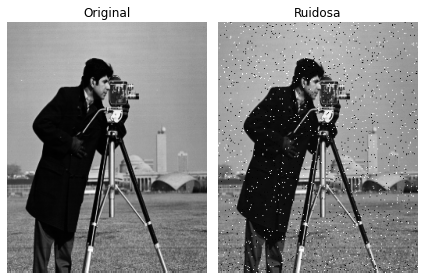

In [24]:
# Visualização
plt.subplot(1,2,1)
plt.imshow(img, 'gray', aspect="auto")
plt.title('Original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(noisy_image, 'gray', aspect="auto")
plt.title('Ruidosa')
plt.axis('off')
plt.tight_layout();

In [25]:
# Aplicando filtro de mediana
median_filtered = cv2.medianBlur(noisy_image, 3)


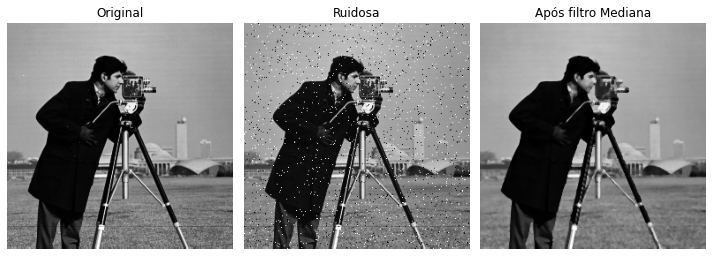

In [26]:
# Visualizando resultado final
plt.figure(figsize=[10,10])
plt.subplot(1,3, 1); plt.imshow(img, 'gray')
plt.title('Original'); plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(noisy_image, 'gray')
plt.title('Ruidosa'); plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(median_filtered, 'gray')
plt.title('Após filtro Mediana'); plt.axis('off')
plt.tight_layout();

## Usando suavização para segmentar um objeto 
**Utilizando o histograma!!** <bn> 
    
Objetivo: separar ao máximo o que é considerado como objeto do que é fundo da imagem.

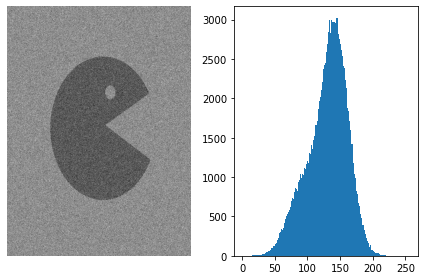

In [27]:
# Lendo imagem e mostrando o seu histograma
pacman = cv2.imread('pacman.tiff', cv2.IMREAD_GRAYSCALE)

plt.subplot(1,2,1), plt.imshow(pacman, 'gray', aspect="auto")
plt.axis('off') 

plt.subplot(1,2,2)
plt.hist(pacman.ravel(), 256, [0, 256]) 
plt.tight_layout();

Devido ao fato que a imagem acima está muito ruidosa, não há como tornarmos a imagem binária utilizando uma transformação de limiarização.

In [28]:
@interact(threshold = IntSlider(min = 0, max = 255, step = 10, value=1))
def _(threshold):
    pacman_thresholded = pacman>threshold
    plt.imshow(pacman_thresholded, 'gray')
    plt.axis('off')
    plt.title('Threshold: '+str(threshold))

  

interactive(children=(IntSlider(value=1, description='threshold', max=255, step=10), Output()), _dom_classes=(…

Solução: ao suavizarmos a imagem, o histograma (mostrado abaixo) passa a apresentar dois picos característicos. O pico à esquerda corresponde ao objeto, enquanto que o pico à direita corresponde ao fundo da imagem. Portanto, um limiar apropriado para a imagem é um valor entre os dois picos.

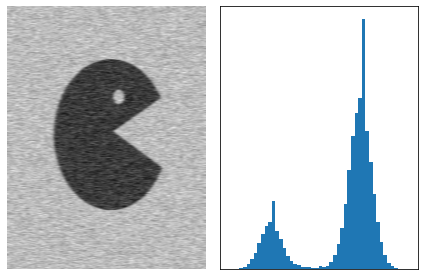

In [29]:
pacman_filtered = cv2.filter2D(pacman, -1, w)

plt.subplot(1,2,1)
plt.imshow(pacman_filtered, 'gray', aspect="auto")
plt.axis('off')

plt.subplot(1,2,2)
_ = plt.hist(pacman_filtered.flatten(), 50)
plt.xticks([]), plt.yticks([])
plt.tight_layout()

Faremos agora a linarização de forma manual, através da escolha de um limiar (threshold) de forma conveniente.

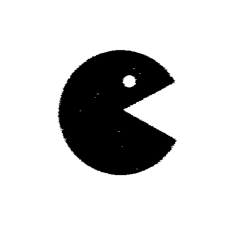

In [30]:
pacman_filt_thresholded = pacman_filtered>110
plt.imshow(pacman_filt_thresholded, 'gray')
plt.axis('off');

In [31]:
# Modo interativo
@interact(threshold = IntSlider(min = 0, max = 255, step = 10))
def _(threshold):
    plt.subplot(1,2,1)
    pacman_filt_thresholded = pacman_filtered>threshold
    plt.imshow(pacman_filt_thresholded, 'gray', aspect="auto")
    plt.title('Imagem original')
    plt.axis('off')
    
    plt.subplot(1,2,2)
    _ = plt.hist(pacman_filtered.flatten(), 50)
    plt.axvline(x=threshold, color = 'r')
    plt.xticks([]), plt.yticks([])
    plt.title('Histograma')
    plt.tight_layout()

interactive(children=(IntSlider(value=0, description='threshold', max=255, step=10), Output()), _dom_classes=(…

# Método de Otsu

Método ótimo e automático para limiarização. <bn>
    
Seu princípio se baseia na ideia de aproximar o histograma de uma imagem por duas funções Gaussianas e escolher o limiar de forma a minimizar a variâcia intra-classes, soma ponderada da variância das duas classes. 

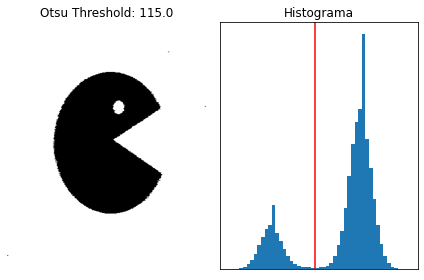

In [32]:
pacman_filtered = np.uint8(pacman_filtered)
otsu_threshold, image_result = cv2.threshold(pacman_filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.subplot(1,2,1)
plt.imshow(image_result, 'gray', aspect="auto")
plt.axis('off')
plt.title('Otsu Threshold: '+str(otsu_threshold));

plt.subplot(1,2,2)
plt.hist(pacman_filtered.flatten(), 50)
plt.axvline(x=otsu_threshold, color = 'r')
plt.xticks([]), plt.yticks([])
plt.title('Histograma'), plt.tight_layout();